# Deploying pre-trained PyTorch VGG19 model with Amazon SageMaker Neo

Amazon SageMaker Neo is API to compile machine learning models to optimize them for our choice of hardward targets. Currently, Neo supports pre-trained PyTorch models from [TorchVision](https://pytorch.org/docs/stable/torchvision/models.html). General support for other PyTorch models is forthcoming.

In this example notebook, we will compare the performace of PyTorch pretrained Vgg19_bn model before versus after compilation using Neo. 

Pytorch Vgg19_bn model is one of the models that benefits a lot from compilation with Neo. Here we will verify that in end to end compilation and inference on sagemaker endpoints, Neo compiled model can get seven times speedup with no loss in accuracy.

In [2]:
!~/anaconda3/envs/pytorch_p36/bin/pip install torch==1.2.0 torchvision==0.4.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
!~/anaconda3/envs/pytorch_p36/bin/pip install --upgrade sagemaker

Requirement already up-to-date: sagemaker in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (2.13.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Import VGG19 from TorchVision

We'll import [VGG19_bn](https://arxiv.org/pdf/1409.1556.pdf) model from TorchVision and create a model artifact `model.tar.gz`:

In [4]:
import torch
import torchvision.models as models
import tarfile

In [5]:
vgg19_bn = models.vgg19_bn(pretrained=True)
input_shape = [1,3,224,224]
trace = torch.jit.trace(vgg19_bn.float().eval(), torch.zeros(input_shape).float())
trace.save('model.pth')

with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add('model.pth')

### Set up the environment

In [26]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('TorchVision-vgg19-Neo')
prefix = compilation_job_name+'/model'

model_path = sess.upload_data(path='model.tar.gz', key_prefix=prefix)

data_shape = '{"input0":[1,3,224,224]}'
target_device = 'ml_c5'
framework = 'PYTORCH'
framework_version = '1.2.0'
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)

### Use sagemaker PyTorchModel to load pretained PyTorch model 

In [7]:
from sagemaker.pytorch.model import PyTorchModel

pt_vgg = PyTorchModel(model_data=model_path,
                      framework_version=framework_version,
                      role=role,                               
                      entry_point='vgg19_bn_old.py',
                      sagemaker_session=sess,
                      py_version='py3'
                     )

### Deploy the pretrained model to prepare for predictions(the old way)

In [8]:
vgg_predictor = pt_vgg.deploy(initial_instance_count = 1,
                              instance_type = 'ml.c5.9xlarge'
                             )

-------------!

### Invoke the endpoint

Let's test with a cat image.

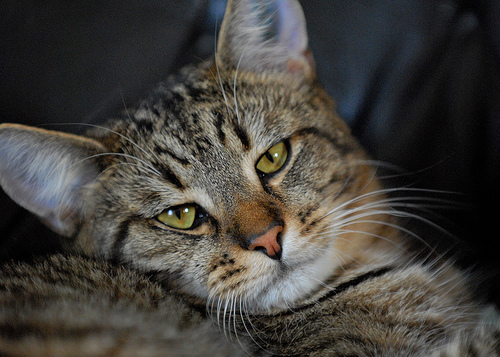

In [9]:
from IPython.display import Image
Image('cat.jpg')  

#### Image Pre-processing

In [10]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
input_image = Image.open('cat.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#### Measure Inference Lantency

In [11]:
import time
start = time.time()
for _ in range(1):
    output = vgg_predictor.predict(input_batch)
inference_time = (time.time()-start)
print('Inference time is ' + str(inference_time) + 'millisecond')

Inference time is 3.4595091342926025millisecond


In [12]:
_, predicted = torch.max(torch.from_numpy(np.array(output)), 1)

In [13]:
# Load names for ImageNet classes
object_categories = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(':')
        object_categories[key] = val

In [14]:
print("Result: label - " + object_categories[str(predicted.item())])

Result: label -  'tiger cat',


### Clean-up
Deleting the local endpoint when you're finished is important since you can only run one local endpoint at a time.

In [15]:
sess.delete_endpoint(vgg_predictor.endpoint_name)

## Neo optimization

### Update framework version

In [27]:
framework_version = '1.4.0'

### Re-create the model archive

In [28]:
with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add('model.pth')

### Create a PyTorch SageMaker model

In [29]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker_model = PyTorchModel(model_data=model_path,
                               predictor_cls=Predictor,
                               framework_version = framework_version,
                               role=role,
                               sagemaker_session=sess,
                               entry_point='vgg19_bn.py',
                               source_dir='code',
                               py_version='py3',
                               env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
                              )

### Use Neo compiler to compile the model

In [30]:
compiled_model = sagemaker_model.compile(target_instance_family=target_device, 
                                         input_shape=data_shape,
                                         job_name=compilation_job_name,
                                         role=role,
                                         framework=framework.lower(),
                                         framework_version=framework_version,
                                         output_path=compiled_model_path
                                        )

?..........................!

In [32]:
# TODO(kkoppolu): Delete after new SDK version sets the image URI correctly
compiled_model.image_uri = compiled_model.image_uri.replace("neo", "inference")

In [33]:
predictor = compiled_model.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.c5.9xlarge'
                                 )

-------------!

In [2]:
import json

with open('cat.jpg', 'rb') as f:
    payload = f.read()
    payload = bytearray(payload) 

#### Measure Inference Lantency

In [35]:
import time
start = time.time()
for _ in range(1000):
    response = predictor.predict(payload)
neo_inference_time = (time.time()-start)
print('Neo optimized inference time is ' + str(neo_inference_time) + 'millisecond')

Neo optimized inference time is 277.70302414894104millisecond


In [1]:
result = json.loads(response.decode())
print('Most likely class: {}'.format(np.argmax(result)))
print("Result: label - " + object_categories[str(np.argmax(result))]+ " probability - " + str(np.amax(result)))

NameError: name 'json' is not defined

In [ ]:
sess.delete_endpoint(predictor.endpoint_name)